# **Model Evaluation**

Defining root folder for root resources access such as `data/` and `utils/`

In [1]:
from pathlib import Path
import sys

ROOT_DIR = Path.cwd().parent  
sys.path.insert(0, str(ROOT_DIR))

## **0. Importing libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from pathlib import Path
from torch import nn
from utils import helpers
import os
from PIL import Image

/home/shiba/Projects/Academics/Nail Disease Detection/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading the data

In [3]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T
from torch.utils.data import DataLoader


# Normalization and transforming data into tensors
transform = T.Compose([
    T.Resize(size=(224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

DATA_DIR = ROOT_DIR / "data"
TEST_DIR = DATA_DIR / "test"
test_data = ImageFolder(root=TEST_DIR,
                        transform=transform,
                        target_transform=None)

class_names = test_data.classes


# Test Dataloader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
OUTPUTS_PATH = ROOT_DIR / "outputs"

## **EfficientNetV2S**

### Rebuilding the model and loading pretrained weights

In [5]:
from torchvision import models

efficientnet_v2_s = models.efficientnet_v2_s()

# Change the output layer to be 10 classes
efficientnet_v2_s.classifier[1] = nn.Linear(efficientnet_v2_s.classifier[1].in_features, len(class_names))
efficientnet_v2_s = efficientnet_v2_s.to(device)

Loading the pretrained weights

In [6]:
WEIGHTS_PATH = OUTPUTS_PATH / "efficientnetv2s" / "weights" / "efficientnetv2s_epoch5.pth"

state_dict = torch.load(f=WEIGHTS_PATH, map_location=device)
efficientnet_v2_s.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

### Evaluating EfficientNetV2S

In [7]:
y_preds, y_true = helpers.make_predictions(model=efficientnet_v2_s,
                                           test_data=test_data,
                                           test_dataloader=test_dataloader,
                                           device=device)

Making predictions: 100%|██████████| 10/10 [00:25<00:00,  2.59s/it]


#### Confusion Matrix

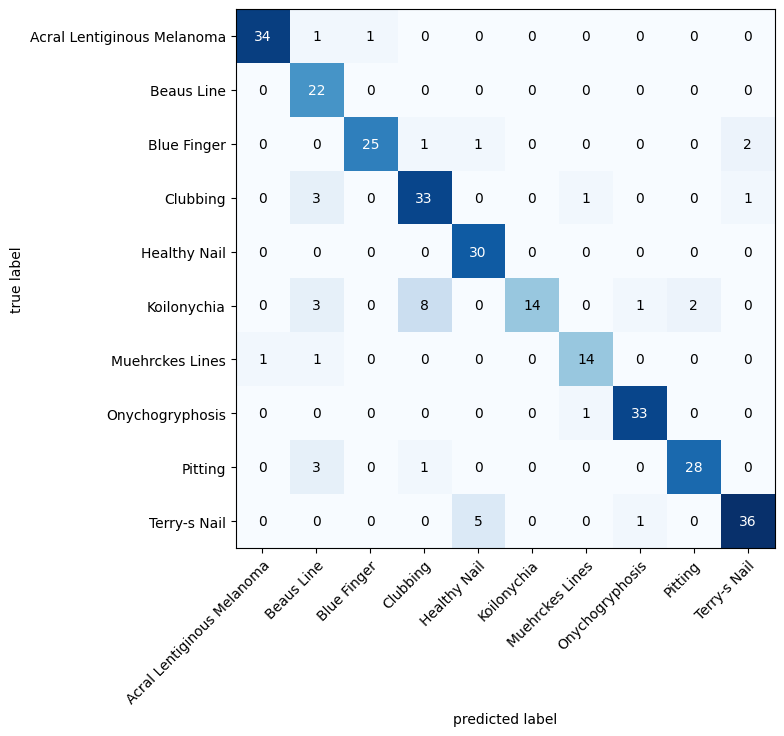

In [8]:
from mlxtend.plotting import plot_confusion_matrix
from torchmetrics import ConfusionMatrix

conf_mat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
conf_mat_tensor = conf_mat(y_preds, y_true)

fig, ax = plot_confusion_matrix(conf_mat=conf_mat_tensor.numpy(), class_names=class_names, figsize=(10,7))

#### Classification Report

In [9]:
from sklearn.metrics import classification_report
report = classification_report(y_preds, y_true, target_names=class_names)
print(report)

                            precision    recall  f1-score   support

Acral Lentiginous Melanoma       0.94      0.97      0.96        35
                Beaus Line       1.00      0.67      0.80        33
               Blue Finger       0.86      0.96      0.91        26
                  Clubbing       0.87      0.77      0.81        43
              Healthy Nail       1.00      0.83      0.91        36
               Koilonychia       0.50      1.00      0.67        14
           Muehrckes Lines       0.88      0.88      0.88        16
           Onychogryphosis       0.97      0.94      0.96        35
                   Pitting       0.88      0.93      0.90        30
              Terry-s Nail       0.86      0.92      0.89        39

                  accuracy                           0.88       307
                 macro avg       0.88      0.89      0.87       307
              weighted avg       0.90      0.88      0.88       307



#### Making a single prediction


 Predicted class index: 8
 Confidence values:
Acral Lentiginous Melanoma: 0.01
Beaus Line: 0.03
Blue Finger: 0.04
Clubbing: 0.00
Healthy Nail: 0.28
Koilonychia: 0.00
Muehrckes Lines: 0.00
Onychogryphosis: 0.00
Pitting: 99.62
Terry-s Nail: 0.00


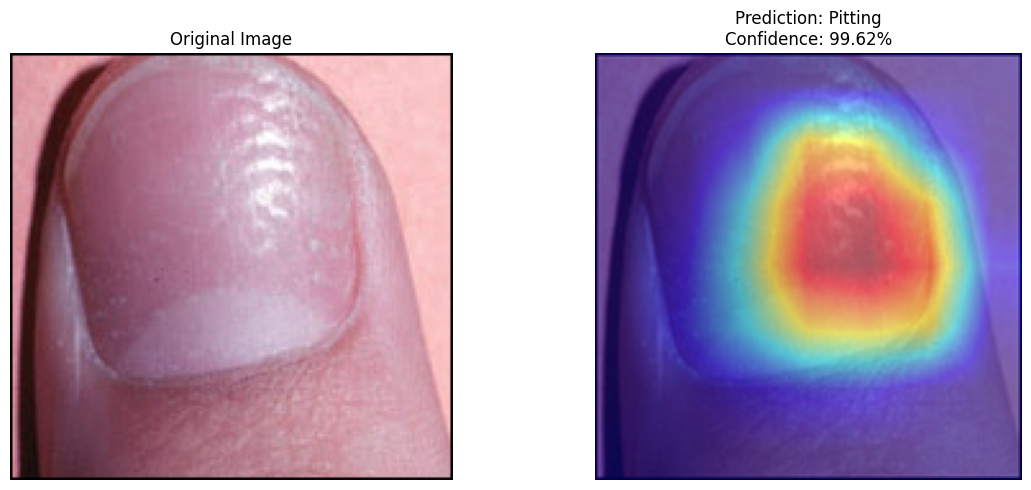

In [18]:
IMAGE_PATH = ROOT_DIR / "13.png"

pred_prob, pred_class, cam_img = helpers.make_single_prediction(
    model=efficientnet_v2_s,
    image_path=IMAGE_PATH,
    class_names=class_names,
    transforms=transform,
    device=device
)
